In [46]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import *

In [47]:
df = pd.read_csv("./DATA/Emotions/emotions.csv")

In [48]:
num_columns = len(df.columns)
print(len(df.index), num_columns)

2132 2549


In [49]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def Oversample(data, labels):
    zeros = []
    ones = []
    for (index, label) in enumerate(labels):
        if label == 0:
            zeros.append(data[index])
        else:
            ones.append(data[index])

    zeros, ones = np.array(zeros), np.array(ones)
    ids = np.arange(len(ones))
    choices = np.random.choice(ids, len(zeros)) #choose entries from so that number of ones and zeroes are the same 

    res_ones_features = ones[choices]
    res_ones_labels = np.ones(len(res_ones_features))

    resampled_features = np.concatenate([res_ones_features, zeros], axis=0)
    resampled_labels = np.concatenate([res_ones_labels, np.zeros(len(zeros))], axis=0)

    return unison_shuffled_copies(resampled_features, resampled_labels)
        

In [50]:
df.head() #each row represents one second

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [51]:
df = df.sample(frac=1) #shuffle dataset
data = df.drop(['label'], axis=1).to_numpy()
labels = df['label'].to_numpy()

In [52]:
all_labels = list(set(labels))
print(all_labels)
class_labels = tfds.features.ClassLabel(names=all_labels)

['POSITIVE', 'NEUTRAL', 'NEGATIVE']


In [53]:
labels = np.array([class_labels.str2int(x) for x in labels])

In [54]:
# total = len(df.index)
# num_zeroes = count
# num_ones = total - num_zeroes
# print(num_zeroes, num_ones)
# zero_weight = (1/num_zeroes)*total/2
# one_weight = (1/num_ones)*total/2
# class_weight = {0: zero_weight, 1: one_weight}
# print(class_weight)

In [55]:
# data, labels = Oversample(data, labels)

In [56]:
norm = np.linalg.norm(data, axis=0)
data = data/norm

In [57]:
assert(len(data) == len(labels))
train, validate, test = np.split(data, [int(.6*len(data)), int(.8*len(data))])
train_labels, validate_labels, test_labels = np.split(labels, [int(.6*len(labels)), int(.8*len(labels))])

In [58]:
print(train.shape, validate.shape, test.shape)

(1279, 2548) (426, 2548) (427, 2548)


In [59]:
TIMESTEPS = 1
def Reshape(input):
    size, features = input.shape
    return input.reshape(size, TIMESTEPS, features)
train, validate, test = Reshape(train), Reshape(validate), Reshape(test)

In [60]:
EPOCHS = 30
BATCH_SIZE = 256
INPUT_SHAPE = (TIMESTEPS, num_columns-1)
DROPOUT = 0.1

In [61]:
def Model():
    input = layers.Input(shape=INPUT_SHAPE)
    cell = layers.LSTMCell(4, dropout=DROPOUT)
    rnn = layers.RNN(cell)(input)
    # fc1 = layers.Dense(128, activation='relu')(rnn)
    output = layers.Dense(3, activation='sigmoid')(rnn)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model
model = Model()
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1, 2548)]         0         
_________________________________________________________________
rnn_3 (RNN)                  (None, 4)                 40848     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 15        
Total params: 40,863
Trainable params: 40,863
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [70]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

history = model.fit(train, train_labels, 
epochs=EPOCHS, 
validation_data=(validate, validate_labels), 
batch_size=BATCH_SIZE, 
verbose=2, 
callbacks=[callback],
# class_weight=class_weight,
shuffle=True)

Epoch 1/30
5/5 - 0s - loss: 1.0684 - accuracy: 0.6333 - val_loss: 1.0128 - val_accuracy: 0.6925
Epoch 2/30
5/5 - 0s - loss: 1.0073 - accuracy: 0.6716 - val_loss: 0.9645 - val_accuracy: 0.7488
Epoch 3/30
5/5 - 0s - loss: 0.9692 - accuracy: 0.7858 - val_loss: 0.9329 - val_accuracy: 0.8521
Epoch 4/30
5/5 - 0s - loss: 0.9379 - accuracy: 0.8311 - val_loss: 0.9051 - val_accuracy: 0.8451
Epoch 5/30
5/5 - 0s - loss: 0.9090 - accuracy: 0.8241 - val_loss: 0.8830 - val_accuracy: 0.8310
Epoch 6/30
5/5 - 0s - loss: 0.8866 - accuracy: 0.8163 - val_loss: 0.8656 - val_accuracy: 0.8380
Epoch 7/30
5/5 - 0s - loss: 0.8695 - accuracy: 0.8256 - val_loss: 0.8513 - val_accuracy: 0.8404
Epoch 8/30
5/5 - 0s - loss: 0.8557 - accuracy: 0.8413 - val_loss: 0.8405 - val_accuracy: 0.8592
Epoch 9/30
5/5 - 0s - loss: 0.8449 - accuracy: 0.8655 - val_loss: 0.8317 - val_accuracy: 0.8709
Epoch 10/30
5/5 - 0s - loss: 0.8364 - accuracy: 0.8874 - val_loss: 0.8243 - val_accuracy: 0.8826
Epoch 11/30
5/5 - 0s - loss: 0.8290 - a

In [71]:
# model.save("./Models/Epilepsy_LSTM1.h5")

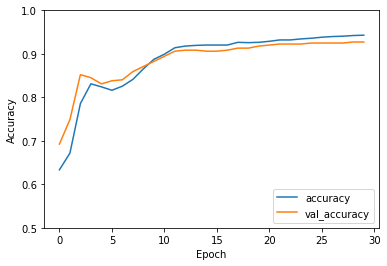

In [72]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [73]:
test_loss, test_acc = model.evaluate(test,  test_labels, verbose=2)

14/14 - 0s - loss: 0.7053 - accuracy: 0.9040


In [74]:
test_labels[:50]

array([0, 2, 0, 2, 2, 2, 2, 1, 2, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 2, 1, 1,
       1, 0, 2, 2, 1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 2, 0, 1, 2, 0, 1, 0, 0,
       1, 0, 2, 1, 2, 2])

In [76]:
# prediction = model.predict(np.expand_dims(test[0], axis=0))
prediction = model.predict(test)
print(prediction.shape)
for (index,p) in enumerate(prediction[:50]):
    # print(p)
    print(class_labels.int2str(np.argmax(p)), class_labels.int2str(test_labels[index]))
    # print(np.argmax(prediction))

(427, 3)
POSITIVE POSITIVE
NEGATIVE NEGATIVE
POSITIVE POSITIVE
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
POSITIVE NEUTRAL
NEGATIVE NEGATIVE
NEUTRAL POSITIVE
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
POSITIVE POSITIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
POSITIVE NEUTRAL
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
POSITIVE POSITIVE
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
NEUTRAL NEUTRAL
POSITIVE POSITIVE
NEUTRAL POSITIVE
NEUTRAL NEUTRAL
NEUTRAL POSITIVE
NEUTRAL NEUTRAL
NEUTRAL NEUTRAL
POSITIVE POSITIVE
NEGATIVE NEGATIVE
NEGATIVE POSITIVE
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
POSITIVE POSITIVE
POSITIVE POSITIVE
NEUTRAL NEUTRAL
POSITIVE POSITIVE
NEGATIVE NEGATIVE
NEUTRAL NEUTRAL
NEGATIVE NEGATIVE
NEGATIVE NEGATIVE
